In [31]:
import meep as mp
import meep.adjoint as mpa
import numpy as np
from autograd import numpy as npa
from autograd import tensor_jacobian_product, grad
import nlopt
from matplotlib import pyplot as plt
from matplotlib.patches import Circle
import math

from meep.materials import Ag

In [32]:
fontlabel = 16

lambda_min = 0.4       # 최소 파장 (µm)
lambda_max = 0.7       # 최대 파장 (µm)
fmin = 1/lambda_max    # 최소 주파수
fmax = 1/lambda_min    # 최대 주파수
fcen = 0.5*(fmin+fmax) # 중앙 주파수

resolution = 50        # 시뮬레이션 해상도
design_region_resolution = 50

# nfreq = 50             # 추출할 주파수 개수
df = fmax-fmin         # 주파수 대역폭

# df = 0
nfreq = 1

In [55]:
tag_bot = 0.5
tag_side = 4
tsio2 = 4
monitor_position = 0.5 * 2
monitor_blank = 0.5 * 0.1
tpml = 0.4

width_ag = 0.2
width_sio2 = 2
width_bot_ag = round(width_ag + width_sio2 + width_ag,2)
design_region_width = round(width_bot_ag, 3)
design_region_height = 0.5

# 시뮬레이션 셀 크기
Sx = tpml + width_bot_ag + tpml
Sy = round(tpml + tag_bot + tag_side + design_region_height + monitor_position + monitor_blank + tpml, 3)
cell_size = mp.Vector3(Sx, Sy)

# 재료
SiO2 = mp.Medium(index=1.45)
TiO2 = mp.Medium(index=2.6)
Air = mp.Medium(index=1.0)

# 디자인 변수 격자
Nx = int(design_region_resolution * design_region_width) + 1
Ny = 1  # 평면 구조

# 위치 계산
y_bottom = -Sy / 2
center_y_ag = y_bottom + tpml + tag_bot / 2
center_y_sio2 = y_bottom + tpml + tag_bot + tsio2 / 2
center_y_design = y_bottom + tpml + tag_bot + tsio2 + design_region_height / 2
center_y_monitor_position = y_bottom + tpml + tag_bot + tsio2 + design_region_height + monitor_position
center_y_source_position = y_bottom + tpml + tag_bot + 5 / fcen
center_Ag_x_position = design_region_width / 2 - width_ag / 2

boundary_layers = [
    # mp.Absorber(tpml, direction=mp.X),
    mp.PML(tpml, direction=mp.Y)
]

In [73]:
# 셀 크기 설정
# cell_size = mp.Vector3(Sx*3, Sy)
cell_size = mp.Vector3(width_bot_ag*3, Sy)

# 기본 지오메트리 정의
geometry = [
    # Bottom Ag layer
    mp.Block(
        material=Ag,
        size=mp.Vector3(width_bot_ag, tag_bot, 0),
        center=mp.Vector3(0, center_y_ag, 0)
    ),
    # SiO2 layer
    mp.Block(
        material=SiO2,
        size=mp.Vector3(width_sio2, tsio2, 0),
        center=mp.Vector3(0, center_y_sio2, 0)
    ),
    # Side metal
    mp.Block(
        material=Ag,
        size=mp.Vector3(width_ag, tsio2, 0),
        center=mp.Vector3(-center_Ag_x_position, center_y_sio2, 0)
    ),
    mp.Block(
        material=Ag,
        size=mp.Vector3(width_ag, tsio2, 0),
        center=mp.Vector3(center_Ag_x_position, center_y_sio2, 0)
    ),
]


In [74]:
# 몇개의 layer로 최적화를 할건지 설정하고 싶다면 layer_num 갯수 조절
layer_num = 1

ML = (layer_num > 1)

region_height_each = design_region_height / layer_num
full_center_y = y_bottom + tag_bot + tsio2 + design_region_height/2

if ML:
    design_variables = []
    design_region = []
    for dv in range(layer_num):
        mg = mp.MaterialGrid(
            mp.Vector3(Nx, Ny),
            TiO2,       
            SiO2,       
            grid_type="U_MEAN",
            do_averaging=False
        )
        design_variables.append(mg)
        offset = ((layer_num - 1) / 2 - dv) * region_height_each
        center_y = full_center_y + offset

        dr = mpa.DesignRegion(
            mg,
            volume=mp.Volume(
                center=mp.Vector3(0, center_y, 0),
                size=mp.Vector3(design_region_width, region_height_each, 0),
            ),
        )
        design_region.append(dr)

        geometry.append(
            mp.Block(
                material=design_variables[dv],
                size=design_region[dv].size,
                center=design_region[dv].center
            )
        )
else:
    design_variables = mp.MaterialGrid(
        mp.Vector3(Nx, Ny),
        TiO2,
        SiO2,
        grid_type="U_MEAN",
        do_averaging=False
    )
    design_region = mpa.DesignRegion(
        design_variables,
        volume=mp.Volume(
            center=mp.Vector3(0, full_center_y, 0),
            size=mp.Vector3(design_region_width, region_height_each, 0),
        )
    )
    geometry.append(
        mp.Block(
            material=design_variables,
            size=design_region.size,
            center=design_region.center
        )
    )


In [106]:
design_layer = np.loadtxt("SingleDipole_sum.txt")
design_variables.update_weights(design_layer)

     block, center = (0,-2.775,0)
          size (2.4,0.5,0)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1,1,1)
     block, center = (0,-0.525,0)
          size (2,4,0)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (2.1025,2.1025,2.1025)
     block, center = (-1.1,-0.525,0)
          size (0.2,4,0)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1,1,1)
     block, center = (1.1,-0.525,0)
          size (0.2,4,0)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1,1,1)
     block, center = (0,1.325,0)
          size (2.4,0.5,0)


          axes (1,0,0), (0,1,0), (0,0,1)


<Axes: xlabel='X', ylabel='Y'>

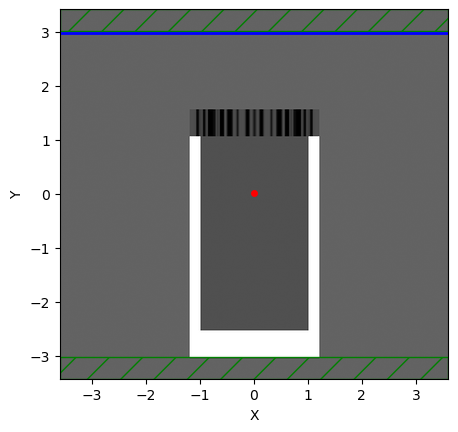

In [122]:
num_sources = 1
spacing = 10 / resolution  

offsets = [ (i - (num_sources - 1) // 2) * spacing for i in range(num_sources) ]

sources = [
    mp.Source(
        mp.GaussianSource(frequency=fcen, fwidth=df, is_integrated=True),
        component=mp.Ez,
        center=mp.Vector3(offset, center_y_source_position, 0)
    )
    for offset in offsets
]


k0 = mp.Vector3(0,0,0)

sims = [
    mp.Simulation(
        resolution=resolution,
        cell_size=cell_size,
        boundary_layers=boundary_layers,
        geometry=geometry,
        sources=[src], 
        default_material=mp.Medium(index=1),
        extra_materials=[Ag],
        k_point=k0
    )
    for src in sources
]

monitor_position_J = mp.Vector3(0, center_y_monitor_position)
monitor_size = mp.Vector3(width_bot_ag*3, 0)

dft_monitor = sims[0].add_dft_fields([mp.Ez], fcen,0,1, center = monitor_position_J, size = monitor_size, yee_grid=True)


sims[0].plot2D()

-----------
Initializing structure...
time for choose_chunkdivision = 8.70228e-05 s
Working in 2D dimensions.
Computational cell is 7.2 x 6.86 x 0 with resolution 50
     block, center = (0,-2.775,0)
          size (2.4,0.5,0)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1,1,1)
     block, center = (0,-0.525,0)
          size (2,4,0)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (2.1025,2.1025,2.1025)
     block, center = (-1.1,-0.525,0)
          size (0.2,4,0)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1,1,1)
     block, center = (1.1,-0.525,0)
          size (0.2,4,0)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1,1,1)
     block, center = (0,1.325,0)
          size (2.4,0.5,0)
          axes (1,0,0), (0,1,0), (0,0,1)
time for set_epsilon = 0.179332 s
lorentzian susceptibility: frequency=16.365, gamma=

run 0 finished at t = 300.0 (30000 timesteps)
     block, center = (0,-2.775,0)
          size (2.4,0.5,0)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1,1,1)
     block, center = (0,-0.525,0)
          size (2,4,0)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (2.1025,2.1025,2.1025)
     block, center = (-1.1,-0.525,0)
          size (0.2,4,0)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1,1,1)
     block, center = (1.1,-0.525,0)
          size (0.2,4,0)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1,1,1)
     block, center = (0,1.325,0)
          size (2.4,0.5,0)
          axes (1,0,0), (0,1,0), (0,0,1)


<Axes: xlabel='X', ylabel='Y'>

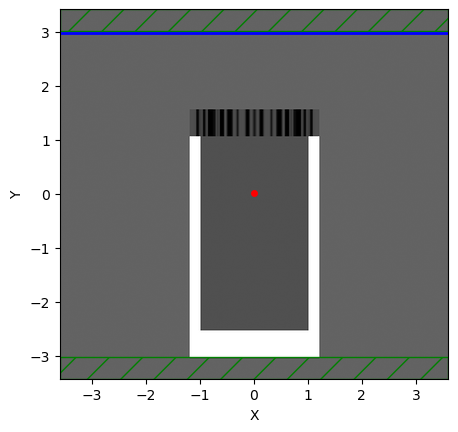

In [123]:
# sims[0].run(until_after_sources=mp.stop_when_fields_decayed(
#             10/df, mp.Ez, sources[0].center, 1e-3
#         ))

# sims[0].run(until_after_sources=mp.stop_when_dft_decayed())
sims[0].run(until=300)
Ez_dft =sims[0].get_dft_array(dft_monitor,mp.Ez,0)

sims[0].plot2D()

     block, center = (0,-2.775,0)
          size (2.4,0.5,0)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1,1,1)


     block, center = (0,-0.525,0)
          size (2,4,0)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (2.1025,2.1025,2.1025)
     block, center = (-1.1,-0.525,0)
          size (0.2,4,0)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1,1,1)
     block, center = (1.1,-0.525,0)
          size (0.2,4,0)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1,1,1)
     block, center = (0,1.325,0)
          size (2.4,0.5,0)
          axes (1,0,0), (0,1,0), (0,0,1)


<Axes: xlabel='X', ylabel='Y'>

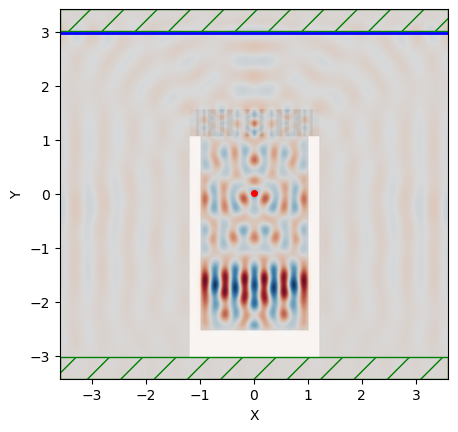

In [124]:
sims[0].plot2D(fields=mp.Ez)

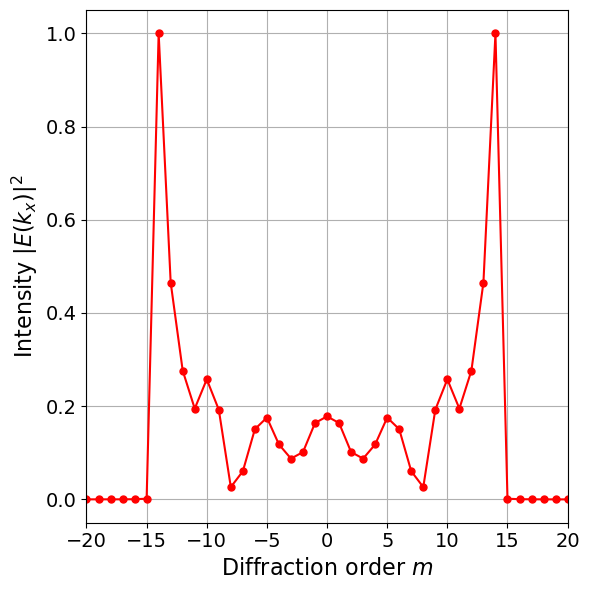

In [126]:
N        = len(Ez_dft)
dx       = 1.0 / resolution
E_k      = np.fft.fftshift(np.fft.fft(Ez_dft)) / N
kx_cycles = np.fft.fftshift(np.fft.fftfreq(N, d=dx))  
kx       = 2 * np.pi * kx_cycles                     

Delta_k = 2*np.pi/(N*dx)
p = kx/Delta_k

plt.figure(figsize=(6,6))
plt.plot(p, np.abs(E_k)**2/max(np.abs(E_k)**2), 'ro-', markersize=5)
plt.xlabel("Diffraction order $m$", fontsize=16)
plt.ylabel(r"Intensity $|E(k_x)|^2$",                   fontsize=16)
plt.xlim(-20, 20) 
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.grid(True)
plt.tight_layout()
plt.show()

In [127]:
k = [0.64669835, 0.50160018, 0.21824349, 0.08710339, 0.26258437,
       0.57216865, 0.72941682, 0.63747624, 0.44835735, 0.38741341,
       0.56314403, 0.85527027, 1.        , 0.85527027, 0.56314403,
       0.38741341, 0.44835735, 0.63747624, 0.72941682, 0.57216865,
       0.26258437, 0.08710339, 0.21824349, 0.50160018, 0.64669835]
k_angle = [-4.32000000e+01, -3.96000000e+01, -3.60000000e+01, -3.24000000e+01,
       -2.88000000e+01, -2.52000000e+01, -2.16000000e+01, -1.80000000e+01,
       -1.44000000e+01, -1.08000000e+01, -7.20000000e+00, -3.60000000e+00,
        1.42108547e-14,  3.60000000e+00,  7.20000000e+00,  1.08000000e+01,
        1.44000000e+01,  1.80000000e+01,  2.16000000e+01,  2.52000000e+01,
        2.88000000e+01,  3.24000000e+01,  3.60000000e+01,  3.96000000e+01,
        4.32000000e+01]

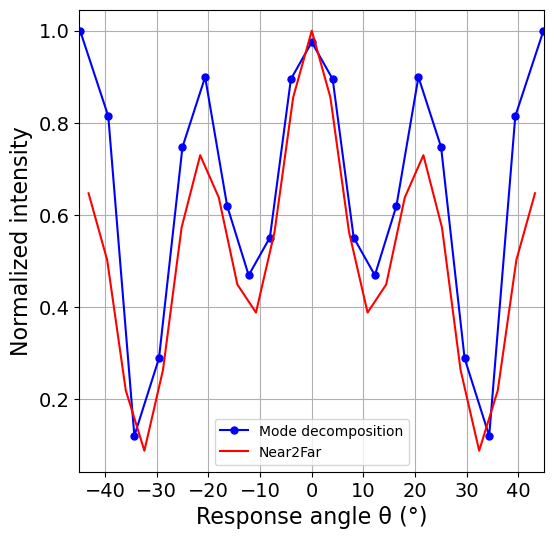

In [128]:
N         = len(Ez_dft)
dx        = 1.0 / resolution
E_k       = np.fft.fftshift(np.fft.fft(Ez_dft)) / N
kx_cycles = np.fft.fftshift(np.fft.fftfreq(N, d=dx))
kx        = 2 * np.pi * kx_cycles

k0 = 2 * np.pi * fcen

ratio      = kx / k0
ratio_clip = np.clip(ratio, -1.0, 1.0)
theta_deg  = np.degrees(np.arcsin(ratio_clip))

P_fft = np.abs(E_k)**2 * (k0 * np.cos(np.radians(theta_deg)))

angle_min = -45
angle_max =  45
mask      = (theta_deg >= angle_min) & (theta_deg <= angle_max)

theta_sel  = theta_deg[mask]      
P_fft_sel  = P_fft[mask]
P_fft_sel /= np.max(P_fft_sel)    

plt.figure(figsize=(6,6))
plt.plot(theta_sel, P_fft_sel, 'bo-', markersize=5,label = "Mode decomposition")
plt.plot(k_angle, k, 'r-', markersize=5, label = "Near2Far")

plt.xlabel("Response angle θ (°)", fontsize=16)
plt.ylabel("Normalized intensity", fontsize=16)
plt.xlim(angle_min, angle_max)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.grid(True)
plt.legend()
plt.show()